In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
sns.set(style="darkgrid")

nltk.download('punkt')
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from tslearn.clustering import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.utils import resample
from tslearn.clustering import KShape
plt.style.use('seaborn-whitegrid')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\march\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\march\anaconda3\envs\ada\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
C:\Users\march\AppData\Local\Temp\ipykernel_28620\2726729349.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Normalizing and dropping neutral, then scaling each emotion

In [3]:
df_emotions = pd.read_pickle("../../data/emotions_interpolated_20.pkl")
df_emotions_raw = pd.read_pickle("../../data/emotions_data_raw.pkl")
df_metadata = pd.read_pickle("../../data/final_dataset.pkl")
emotion_columns = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
df_emotions

,anger,disgust,fear,joy,neutral,sadness,surprise,Wikipedia_movie_ID,timestep
0,0.008854,0.029581,0.002972,0.115284,0.753907,0.025629,0.063773,3333,0
1,0.020809,0.070973,0.033560,0.082080,0.771024,0.012630,0.008924,3333,1
2,0.016042,0.078240,0.065199,0.005752,0.066704,0.763973,0.004088,3333,2
3,0.007964,0.042619,0.052491,0.003172,0.091407,0.785047,0.017299,3333,3
4,0.080363,0.090461,0.030861,0.007990,0.272579,0.512997,0.004750,3333,4
...,...,...,...,...,...,...,...,...,...
686835,0.015265,0.148570,0.114552,0.009460,0.555081,0.134403,0.022669,37373877,15
686836,0.014070,0.187139,0.126397,0.011102,0.487088,0.170217,0.003987,37373877,16
686837,0.011060,0.132366,0.085783,0.008578,0.638195,0.118761,0.005258,37373877,17
686838,0.008050,0.077592,0.045170,0.006053,0.789302,0.067304,0.006528,37373877,18


Getting rid of movies with too small amount of sentences since K-shape needs same size time series

In [4]:
df_emotions_raw['sentence_id'] = (df_emotions_raw.groupby('Wikipedia_movie_ID').cumcount() + 1)
sentence_counts = df_emotions_raw.groupby('Wikipedia_movie_ID').size()
valid_movies = sentence_counts[(sentence_counts >= 10) & (sentence_counts <= 80)].index
print(len(valid_movies))
df_emotions = df_emotions[df_emotions['Wikipedia_movie_ID'].isin(valid_movies)]
df_emotions.reset_index(drop=True, inplace=True)

24474


Grouping by emotions

In [5]:
anger_df = df_emotions[["anger", "Wikipedia_movie_ID", "timestep"]]
anger_df = anger_df.pivot(index='Wikipedia_movie_ID', columns='timestep', values='anger')
X_anger = anger_df.values
X_anger = TimeSeriesScalerMinMax().fit_transform(X_anger)

joy_df = df_emotions[["joy", "Wikipedia_movie_ID", "timestep"]]
joy_df = joy_df.pivot(index='Wikipedia_movie_ID', columns='timestep', values='joy')
X_joy = joy_df.values
X_joy = TimeSeriesScalerMinMax().fit_transform(X_joy)


disgust_df = df_emotions[["disgust", "Wikipedia_movie_ID", "timestep"]]
disgust_df = disgust_df.pivot(index='Wikipedia_movie_ID', columns='timestep', values='disgust')
X_disgust = disgust_df.values
X_disgust = TimeSeriesScalerMinMax().fit_transform(X_disgust)

fear_df = df_emotions[["fear", "Wikipedia_movie_ID", "timestep"]]
fear_df = fear_df.pivot(index='Wikipedia_movie_ID', columns='timestep', values='fear')
X_fear = fear_df.values
X_fear = TimeSeriesScalerMinMax().fit_transform(X_fear)

neutral_df = df_emotions[["neutral", "Wikipedia_movie_ID", "timestep"]]
neutral_df = neutral_df.pivot(index='Wikipedia_movie_ID', columns='timestep', values='neutral')
X_neutral = neutral_df.values
X_neutral = TimeSeriesScalerMinMax().fit_transform(X_neutral)

sadness_df = df_emotions[["sadness", "Wikipedia_movie_ID", "timestep"]]
sadness_df = sadness_df.pivot(index='Wikipedia_movie_ID', columns='timestep', values='sadness')
X_sadness = sadness_df.values
X_sadness = TimeSeriesScalerMinMax().fit_transform(X_sadness)

surprise_df = df_emotions[["surprise", "Wikipedia_movie_ID", "timestep"]]
surprise_df = surprise_df.pivot(index='Wikipedia_movie_ID', columns='timestep', values='surprise')
X_surprise = surprise_df.values
X_surprise = TimeSeriesScalerMinMax().fit_transform(X_surprise)

In [6]:
df_genres = df_metadata[['Wikipedia_movie_ID', 'category']]
df_genres = df_genres[df_genres['Wikipedia_movie_ID'].isin(valid_movies)]
emotions_data = {"anger": X_anger, "joy": X_joy, "disgust": X_disgust, "fear": X_fear, "neutral": X_neutral, "sadness": X_sadness, "surprise": X_surprise}

In [53]:
def plot_elbow_kshape(X, subsample, emotion_title):
    subsample_size = min(subsample, len(X))
    X_subsample = resample(X, n_samples=subsample_size, random_state=0)

    inertias = []
    for k in range(2, 10):  # No tqdm here to avoid nested progress bars
        kshape_model = KShape(n_clusters=k, verbose=False, random_state=0)
        kshape_model.fit(X_subsample)
        inertias.append(kshape_model.inertia_)

    # Plot the Elbow Curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, 10), inertias, 'o-', markerfacecolor='red')
    plt.title(f"Elbow Method for {emotion_title}")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia (Sum of Squared Distances)")
    plt.grid(True, linestyle=":")
    plt.show()

def plot_elbow_for_all_emotions(emotion_data, subsample):
    # Add a tqdm wrapper around the iteration over emotions
    for emotion, X in tqdm(emotion_data.items(), desc="Processing all emotions", unit="emotion"):
        plot_elbow_kshape(X, subsample, emotion_title=emotion)

In [6]:
def plot_clusters(X, y , title, nb_clusters):

    for cluster_id in range(nb_clusters):
        cluster_indices = np.where(y == cluster_id)[0]
        if len(cluster_indices) == 0:
            print(f"Cluster {cluster_id} is empty. Skipping...")
            continue
        
        cluster_data = X[cluster_indices]

        # Calculate average anger evolution and standard deviation
        avg_anger_evolution = np.mean(cluster_data, axis=0)
        anger_variance = np.std(cluster_data, axis=0)

        # Plot cluster details
        plt.figure(figsize=(8, 5))
        plt.plot(avg_anger_evolution, label=f'Cluster {cluster_id + 1} (Avg)', 
                color='#D32F2F', linewidth=3, zorder=5)
        plt.plot(avg_anger_evolution + anger_variance, 'k--', 
                label="Variance (+1 SD)", linewidth=2, zorder=4)
        plt.plot(avg_anger_evolution - anger_variance, 'k--', 
                label="Variance (-1 SD)", linewidth=2, zorder=4)

        # Enhance visualization
        plt.title(f"Evolution of {title} for Cluster {cluster_id + 1}", fontsize=16, fontweight='bold')
        plt.xlabel("Time Step", fontsize=14)
        plt.ylabel("Joy Intensity", fontsize=14)
        plt.legend(loc='upper right', fontsize=12, frameon=False)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.xlim(0, len(avg_anger_evolution) - 1)
        plt.ylim(min(avg_anger_evolution - anger_variance) - 0.05, 
                max(avg_anger_evolution + anger_variance) + 0.05)
        plt.gca().set_facecolor('#f9f9f9')
        
        # Adjust layout and display
        plt.tight_layout()
        plt.show()

In [39]:
def plot_clusters_stats(df_y, df_metadata):
    
    df_genres = df_metadata[['Wikipedia_movie_ID', 'category']]
    df_genres = df_genres[df_genres['Wikipedia_movie_ID'].isin(valid_movies)]
    df = pd.merge(df_y, df_genres, on='Wikipedia_movie_ID', how='inner')
    
    # Step 1: Explode the 'category' column if it contains lists of genres
    df_exploded = df.explode('category')

    # Step 2: Group by cluster and genre (category) to count occurrences
    genre_distribution = df_exploded.groupby(['cluster_label', 'category']).size().unstack(fill_value=0)
    
    # Step 3: Normalize counts to get proportions for each cluster
    genre_proportions = genre_distribution.div(genre_distribution.sum(axis=1), axis=0)
    
    # Step 4: Count the number of films in each cluster
    cluster_counts = df.groupby('cluster_label').size()

    # --------------- FIRST PLOT: Histogram for the Number of Films in Each Cluster ---------------
    fig, ax1 = plt.subplots(figsize=(10, 6))

    bars = ax1.bar(cluster_counts.index, cluster_counts, color='skyblue', edgecolor='black')
    ax1.set_title("Number of Films in Each Cluster", fontsize=16, fontweight='bold')
    ax1.set_xlabel("Cluster", fontsize=14)
    ax1.set_ylabel("Number of Films", fontsize=14)
    ax1.grid(axis='y', linestyle=':', alpha=0.7)

    # Add counts above each bar
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

    # --------------- SECOND PLOT: Stacked Bar Chart for Genre Proportions ---------------
    fig, ax2 = plt.subplots(figsize=(10, 7))

    # Initialize bottom for stacking
    bottom = np.zeros(len(cluster_counts))

    # Plot the genre proportions as stacked bars (normalized)
    for genre in genre_proportions.columns:
        # Get the genre proportions for each cluster
        genre_proportions_scaled = genre_proportions[genre]  # Already normalized to sum to 1
        bar_segment = ax2.bar(cluster_counts.index, genre_proportions_scaled, bottom=bottom, label=genre)  # Plot stacked portion
        
        # Add percentages for each genre
        for i, rect in enumerate(bar_segment):
            percentage = genre_proportions_scaled.iloc[i] * 100  # Calculate percentage
            ax2.text(
                rect.get_x() + rect.get_width() / 2,  # X position (center of the bar)
                rect.get_height() + bottom[i],  # Y position (top of the segment)
                f'{percentage:.1f}%',  # Display percentage with one decimal
                ha='center', va='bottom', fontsize=10, color='black'  # Style the text
            )
        
        bottom += genre_proportions_scaled  # Update bottom for next genre stack

    # Add labels and title
    ax2.set_title("Normalized Genre Proportions in Each Cluster", fontsize=16, fontweight='bold')
    ax2.set_xlabel("Cluster", fontsize=14)
    ax2.set_ylabel("Proportion of Films", fontsize=14)
    ax2.set_xticks(cluster_counts.index)
    
    # Move legend outside the plot area
    ax2.legend(title="Genres", fontsize=12, frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show grid and tight layout
    ax2.grid(axis='y', linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()
    

# Plot all elbows

Processing all emotions:   0%|          | 0/7 [00:00<?, ?emotion/s]

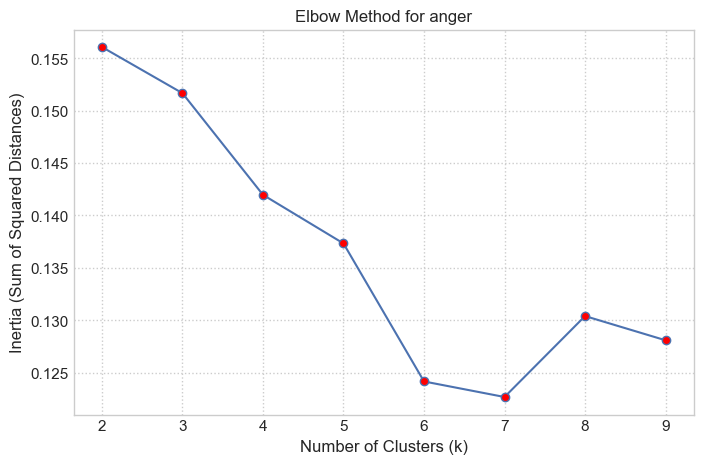

Processing all emotions:  14%|█▍        | 1/7 [23:36<2:21:40, 1416.78s/emotion]

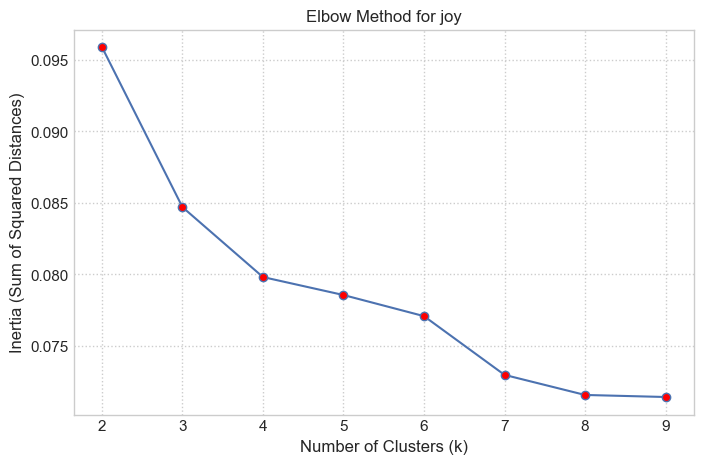

Processing all emotions:  29%|██▊       | 2/7 [42:06<1:43:01, 1236.32s/emotion]

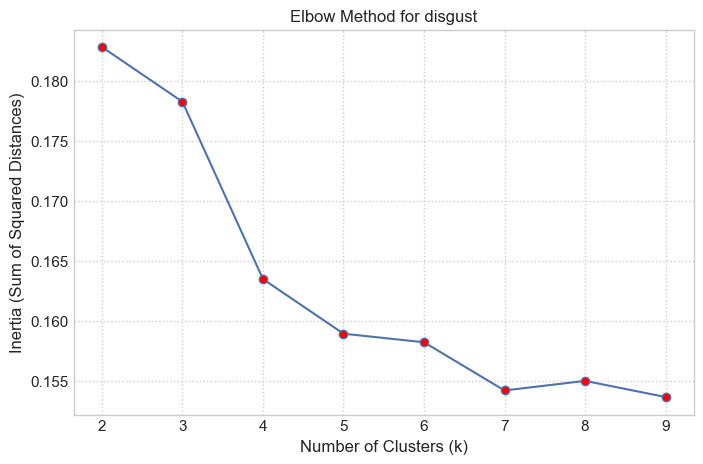

Processing all emotions:  43%|████▎     | 3/7 [1:10:32<1:36:42, 1450.52s/emotion]

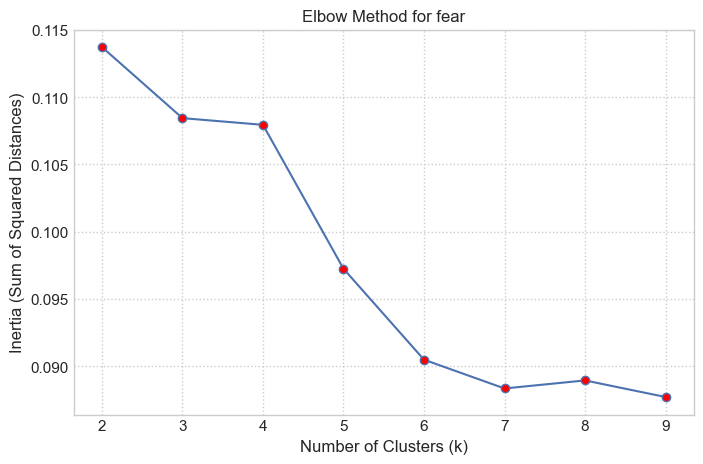

Processing all emotions:  57%|█████▋    | 4/7 [1:31:00<1:08:08, 1362.93s/emotion]

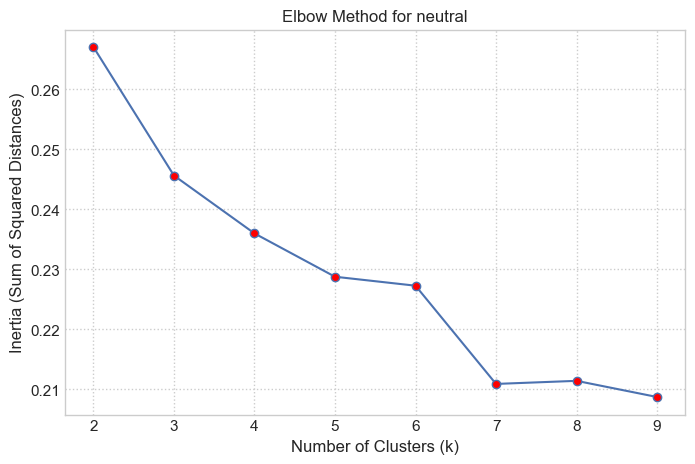

Processing all emotions:  71%|███████▏  | 5/7 [2:00:19<50:11, 1505.58s/emotion]  

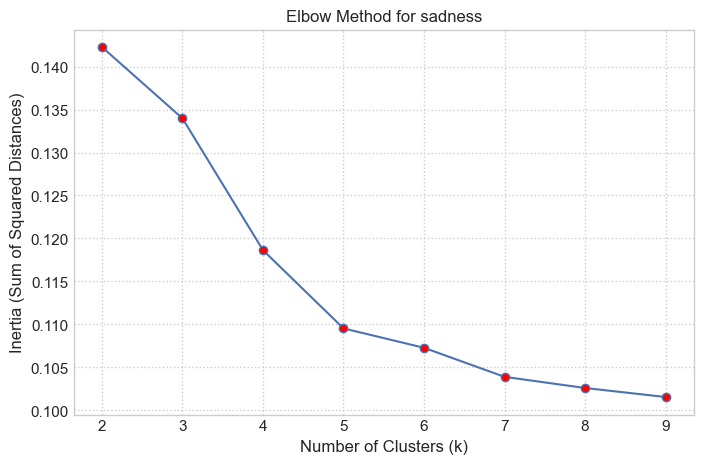

Processing all emotions:  86%|████████▌ | 6/7 [2:25:41<25:11, 1511.10s/emotion]

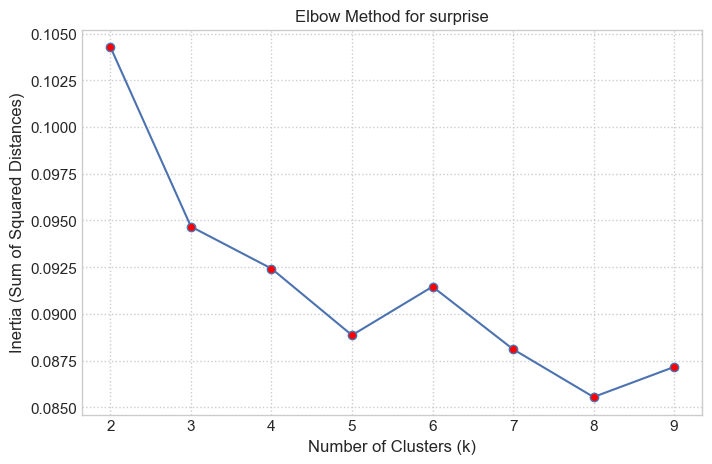

Processing all emotions: 100%|██████████| 7/7 [2:52:48<00:00, 1481.21s/emotion]


In [62]:
plot_elbow_for_all_emotions(emotions_data, 24474)

# Joy K-shape

In [63]:
model = KShape(n_clusters=4, verbose=True, random_state=0)
y_joy = model.fit(X_joy).predict(X_joy)
y_joy_df = pd.DataFrame({'Wikipedia_movie_ID': df_genres["Wikipedia_movie_ID"], 'cluster_label': y_joy})

0.088 --> 0.084 --> 0.085 --> 


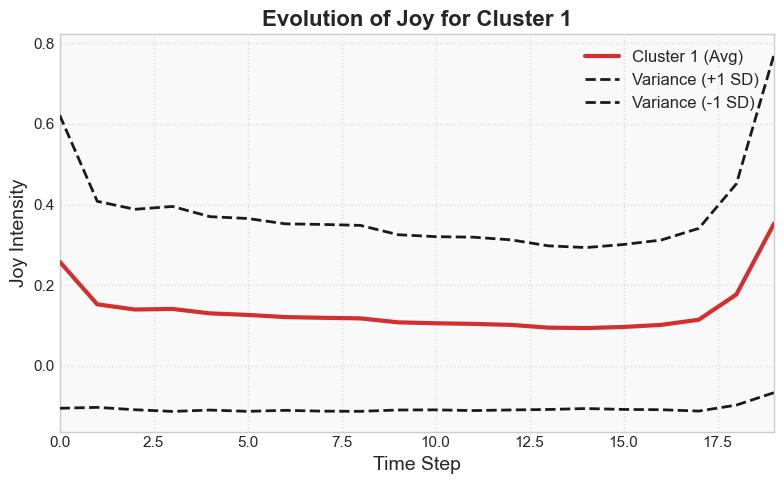

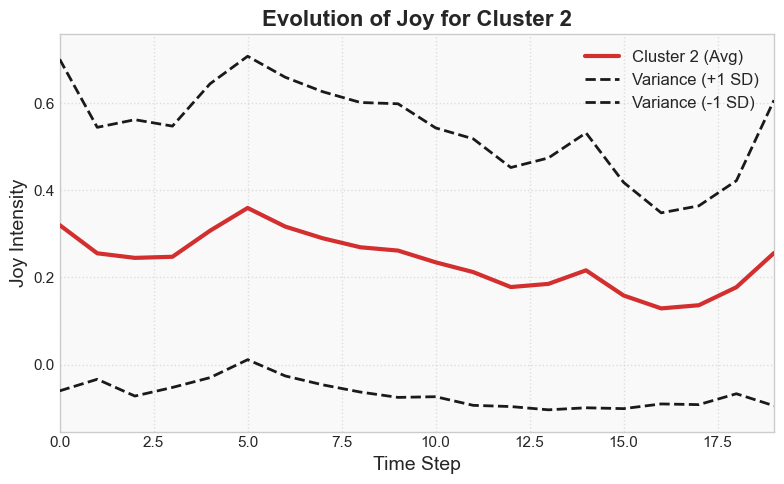

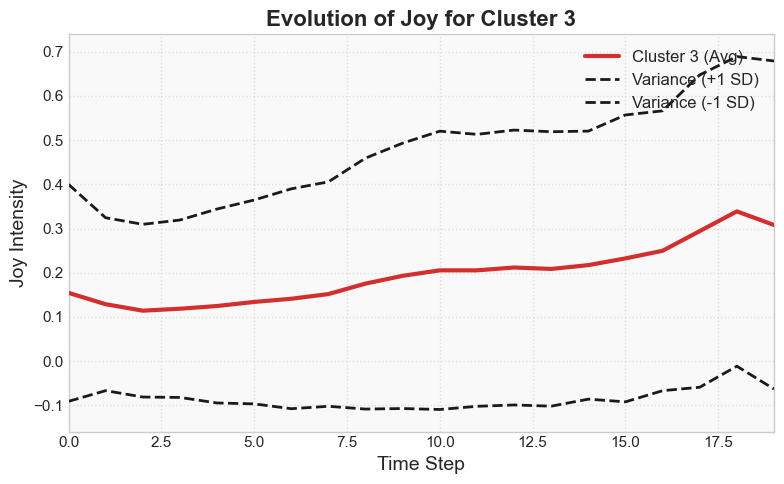

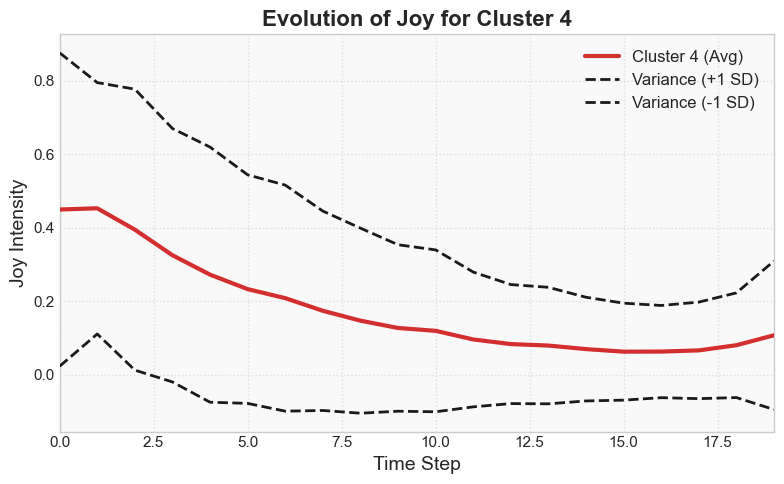

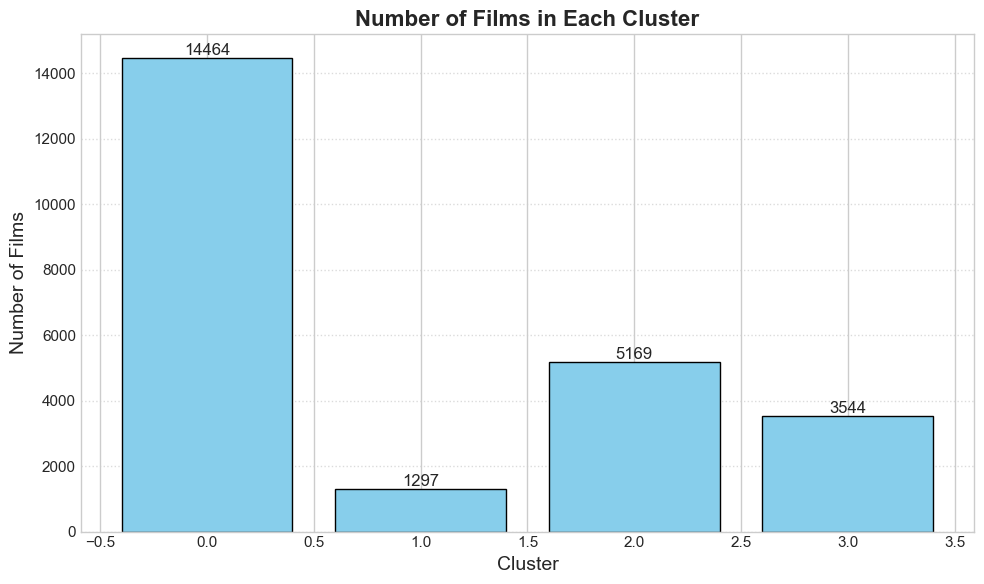

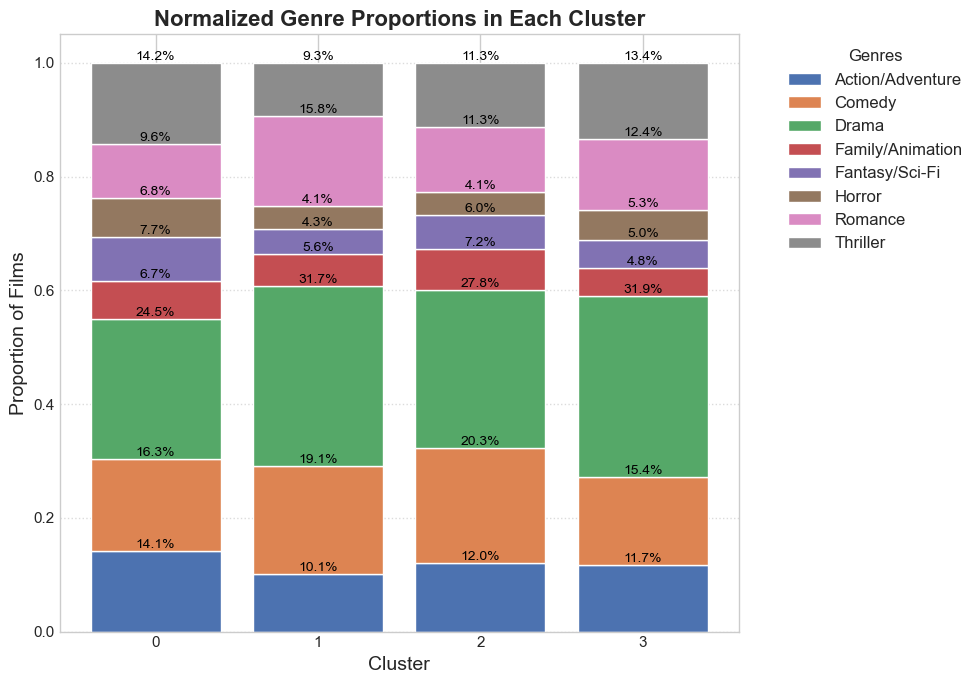

In [64]:
plot_clusters(X_joy, y_joy, "Joy", 4)
plot_clusters_stats(y_joy_df, df_metadata)

# Surprise K-shape

In [65]:
model = KShape(n_clusters=5, verbose=True, random_state=0)
y_surprise = model.fit(X_surprise).predict(X_surprise)
y_surprise_df = pd.DataFrame({'Wikipedia_movie_ID': df_genres["Wikipedia_movie_ID"], 'cluster_label': y_surprise})

0.094 --> 0.096 --> 


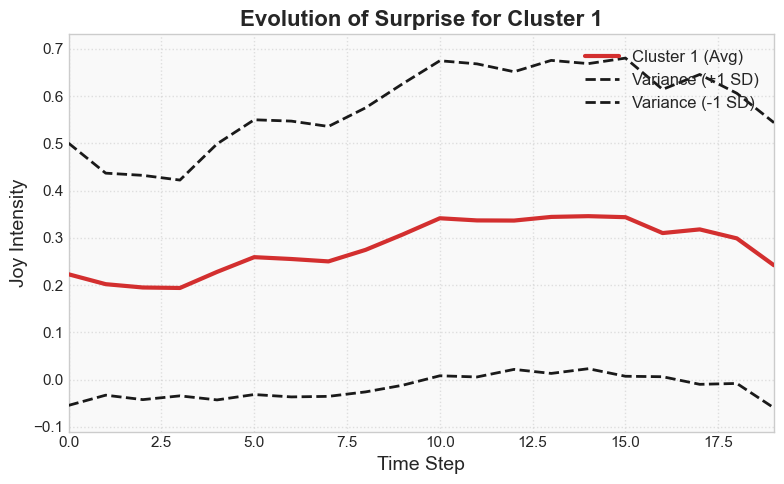

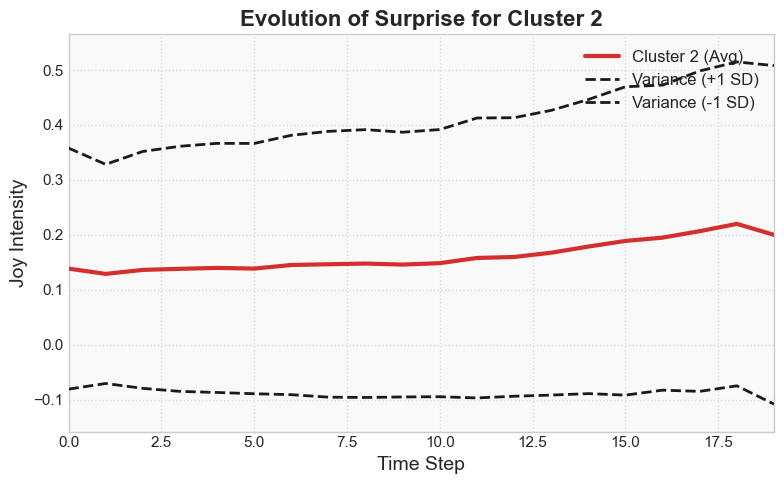

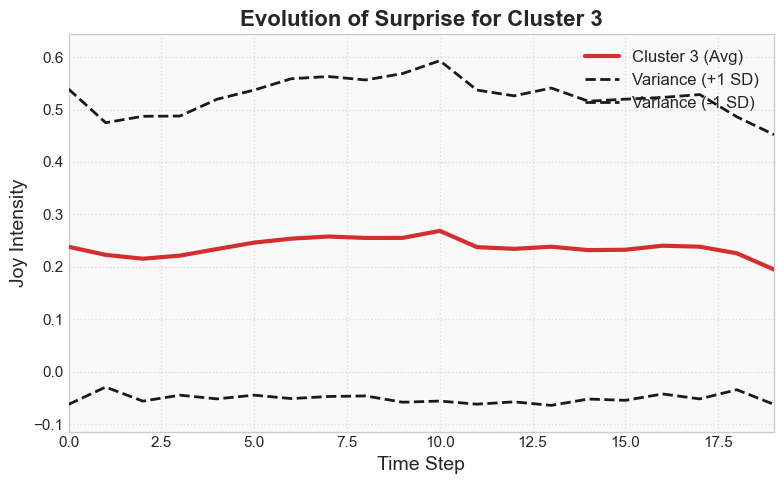

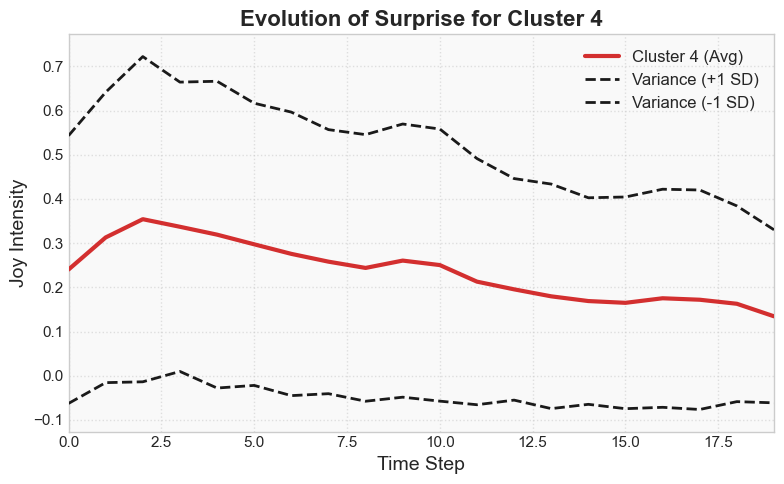

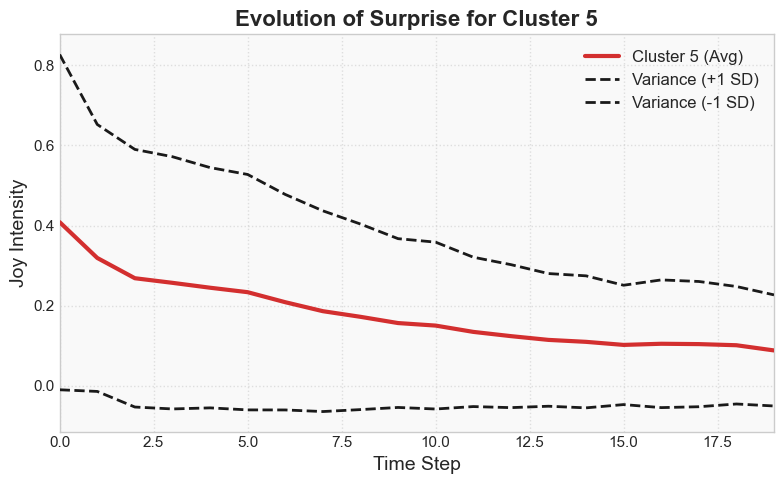

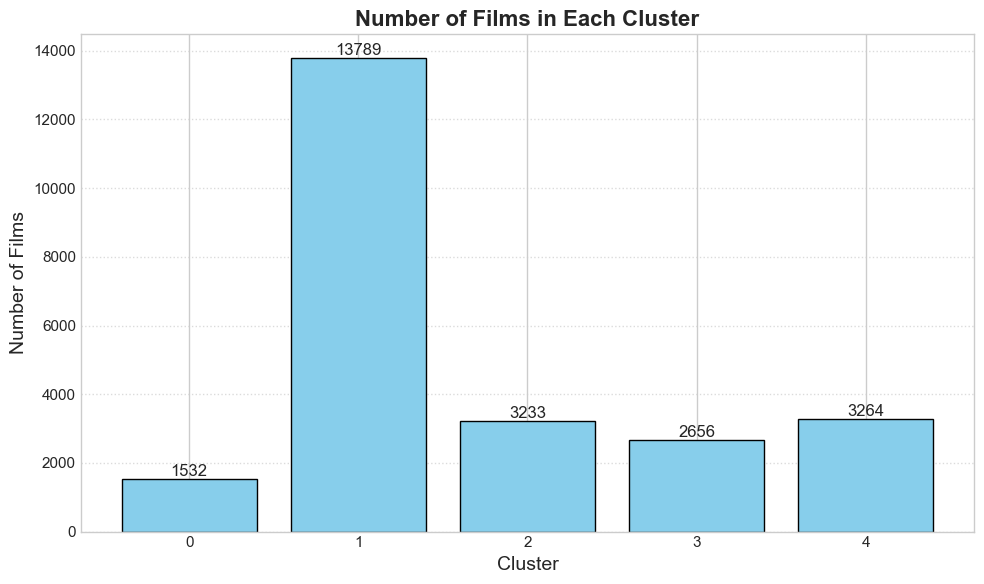

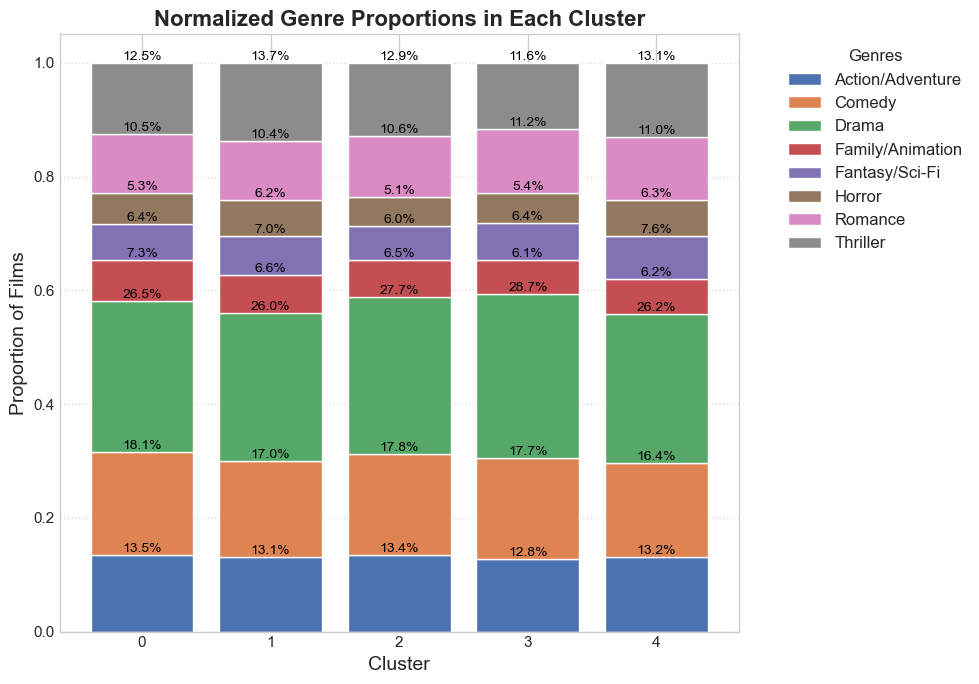

In [66]:
plot_clusters(X_surprise, y_surprise, "Surprise", 5)
plot_clusters_stats(y_surprise_df, df_metadata)

# Anger K-shape

In [67]:
model = KShape(n_clusters=6, verbose=True, random_state=0)
y_anger = model.fit(X_anger).predict(X_anger)
y_anger_df = pd.DataFrame({'Wikipedia_movie_ID': df_genres["Wikipedia_movie_ID"], 'cluster_label': y_anger})

0.159 --> 0.143 --> 0.135 --> 0.135 --> 0.133 --> 0.133 --> 0.130 --> 0.131 --> 


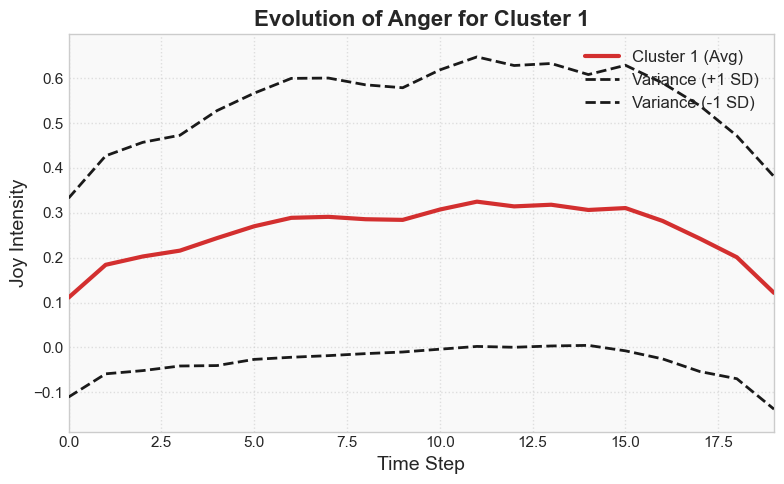

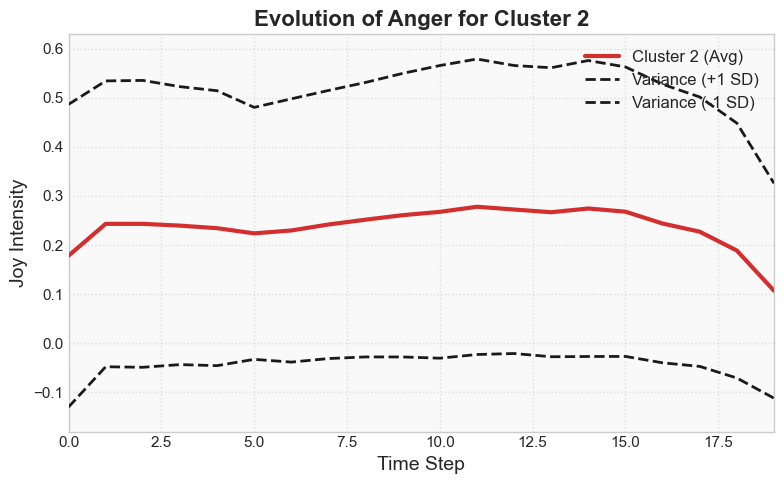

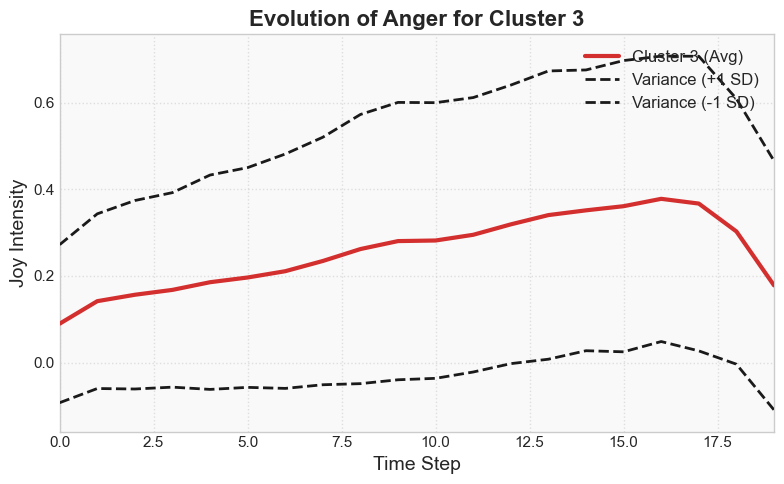

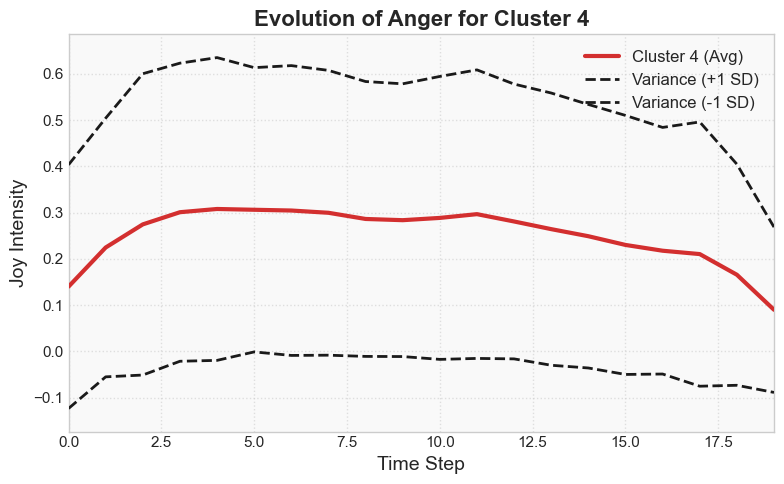

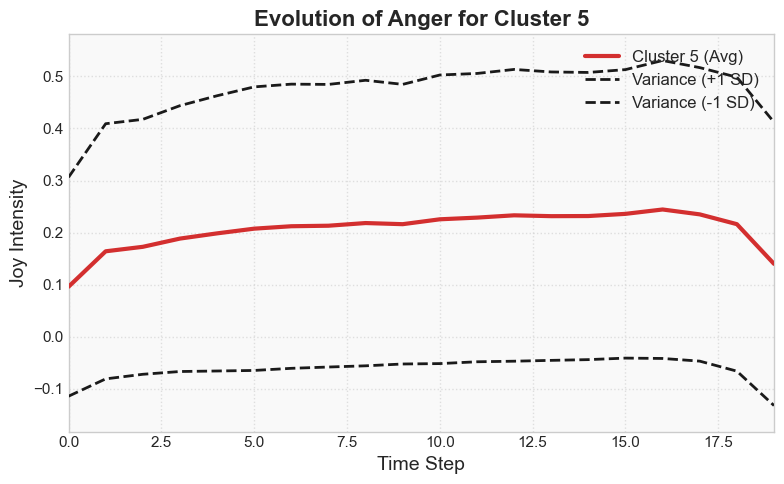

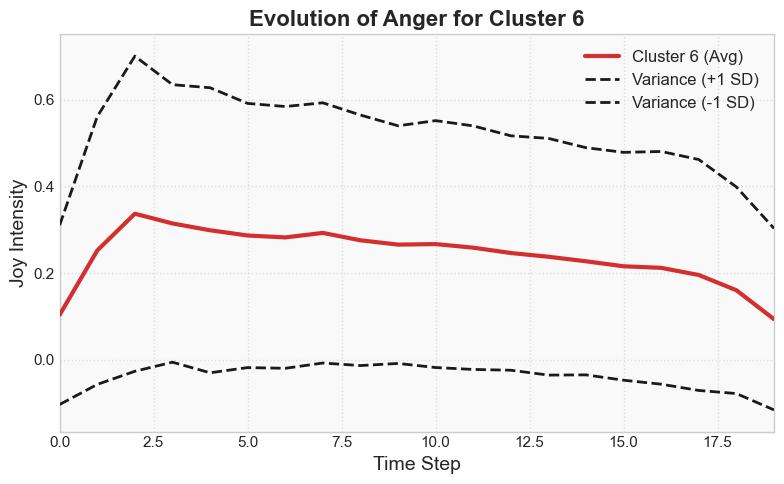

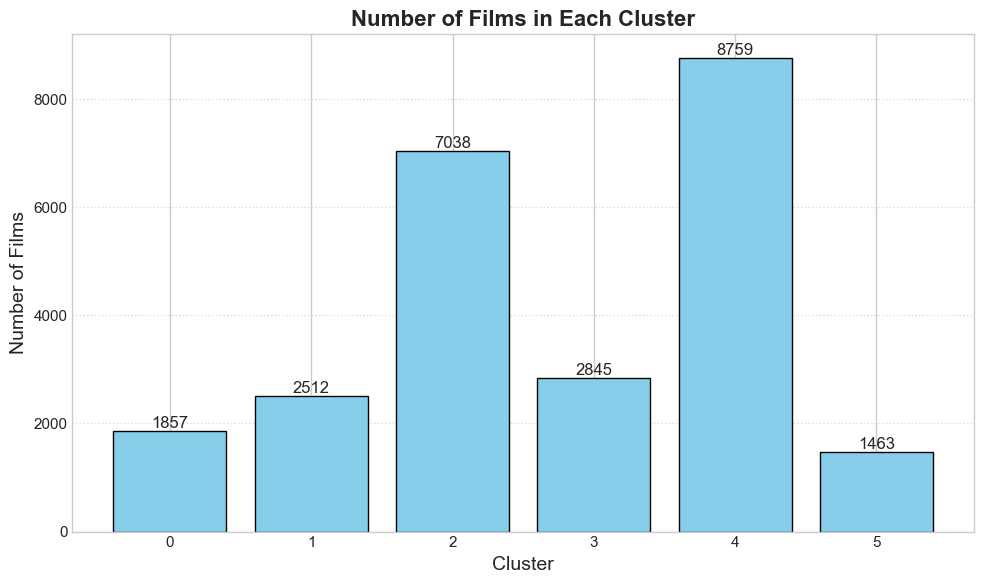

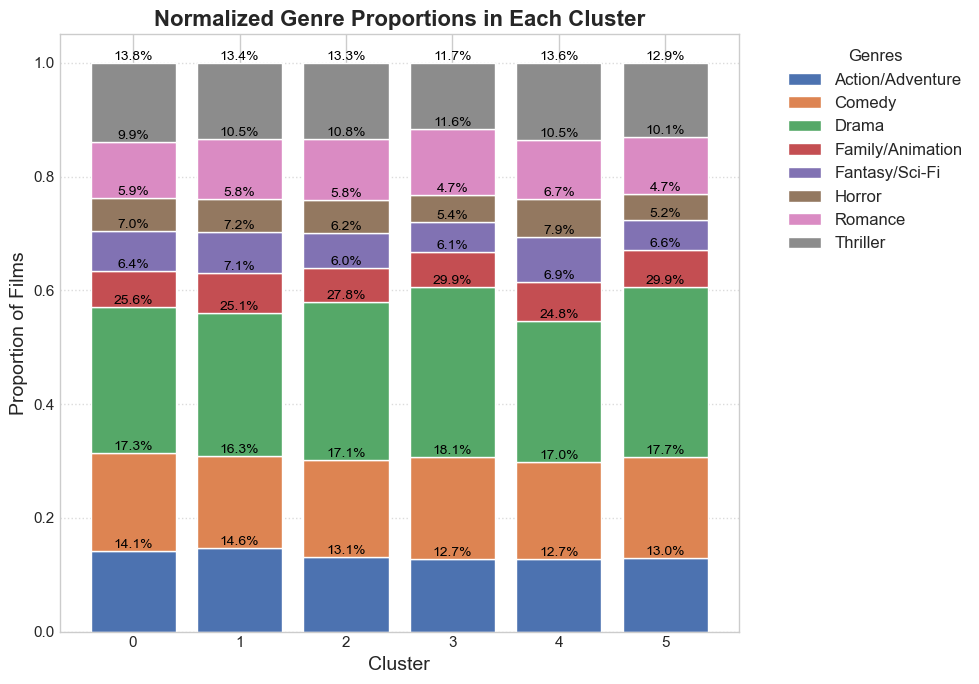

In [68]:
plot_clusters(X_anger, y_anger, "Anger", 6)
plot_clusters_stats(y_anger_df, df_metadata)

# Sadness K-shape

In [69]:
model = KShape(n_clusters=5, verbose=True, random_state=0)
y_sadness = model.fit(X_sadness).predict(X_sadness)
y_sadness_df = pd.DataFrame({'Wikipedia_movie_ID': df_genres["Wikipedia_movie_ID"], 'cluster_label': y_sadness})

0.135 --> 0.126 --> 0.122 --> 0.121 --> 0.120 --> 0.121 --> 


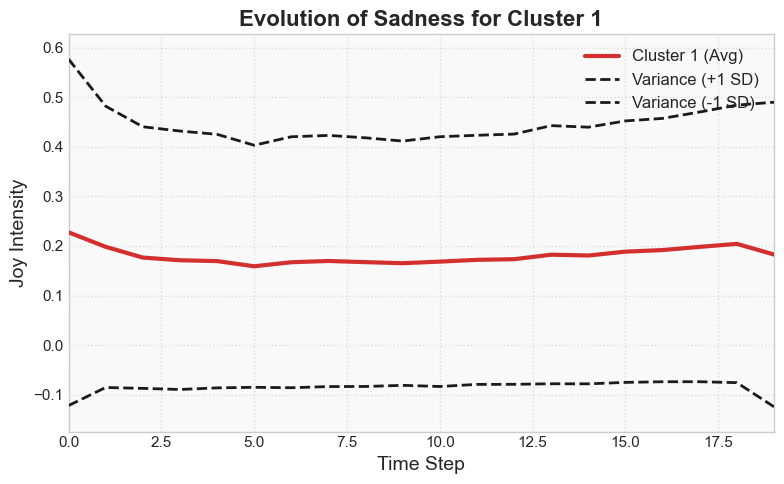

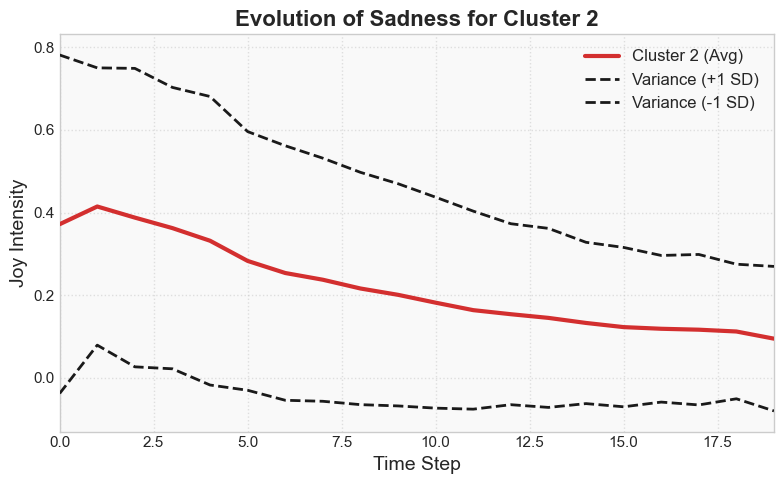

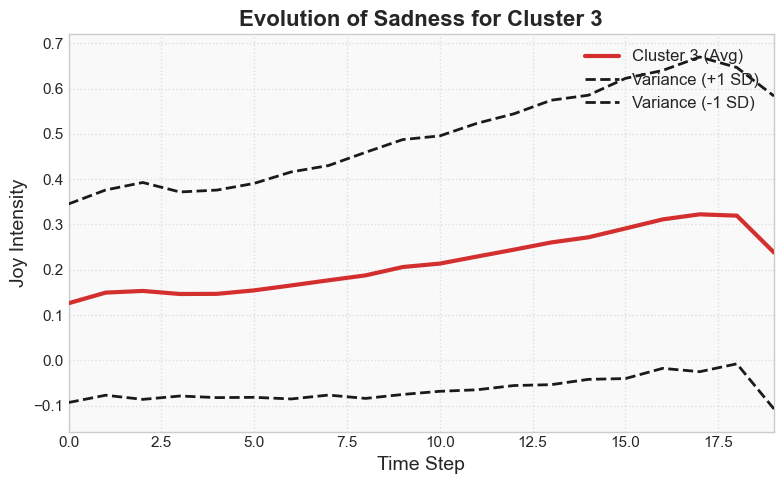

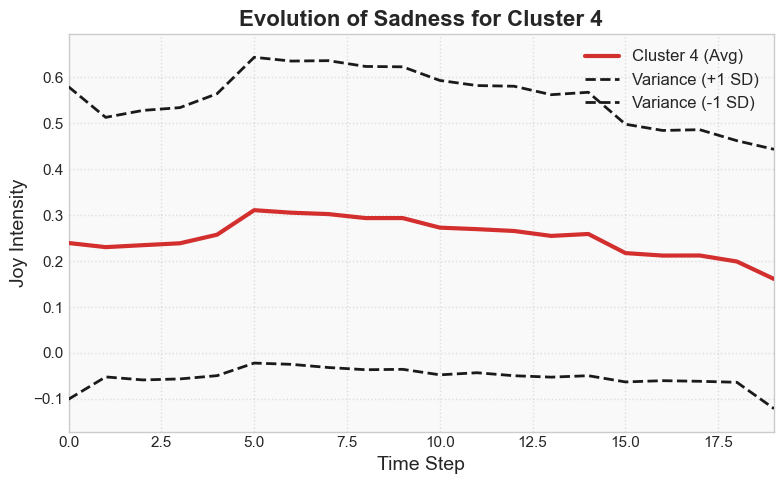

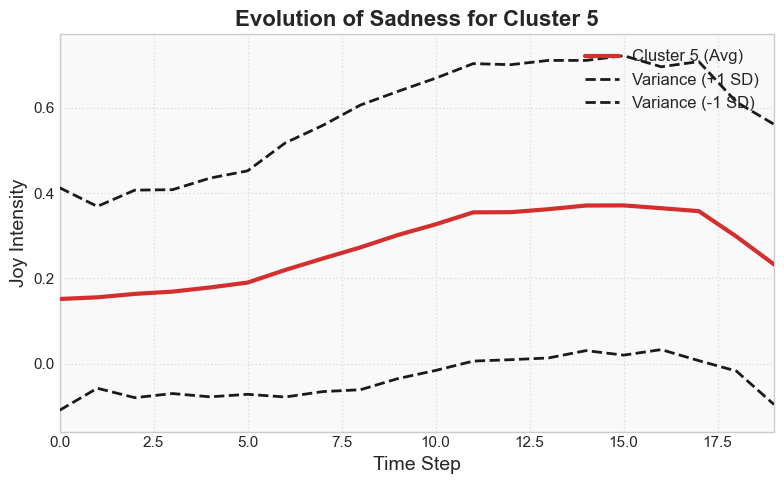

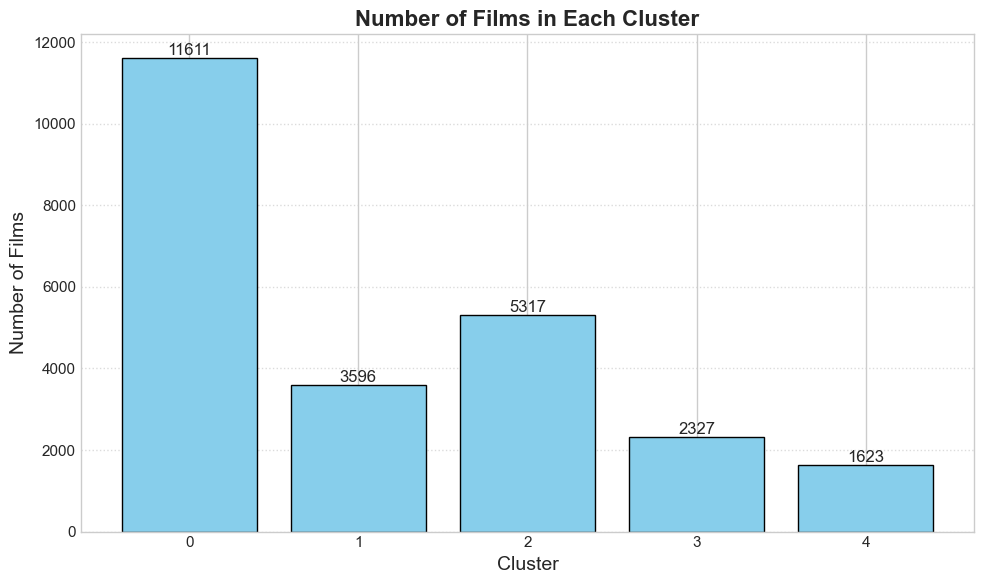

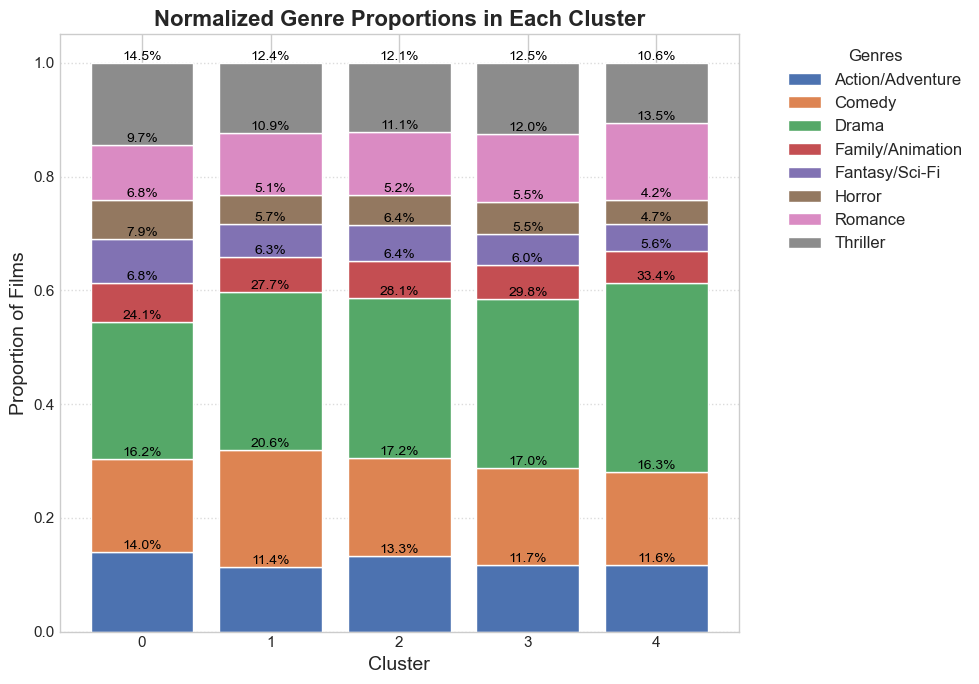

In [70]:
plot_clusters(X_sadness, y_sadness, "Sadness", 5)
plot_clusters_stats(y_sadness_df, df_metadata)

# Disgust K-shape

In [71]:
model = KShape(n_clusters=5, verbose=True, random_state=0)
y_disgust = model.fit(X_disgust).predict(X_disgust)
y_disgust_df = pd.DataFrame({'Wikipedia_movie_ID': df_genres["Wikipedia_movie_ID"], 'cluster_label': y_disgust})

0.214 --> 0.188 --> 0.180 --> 0.199 --> 


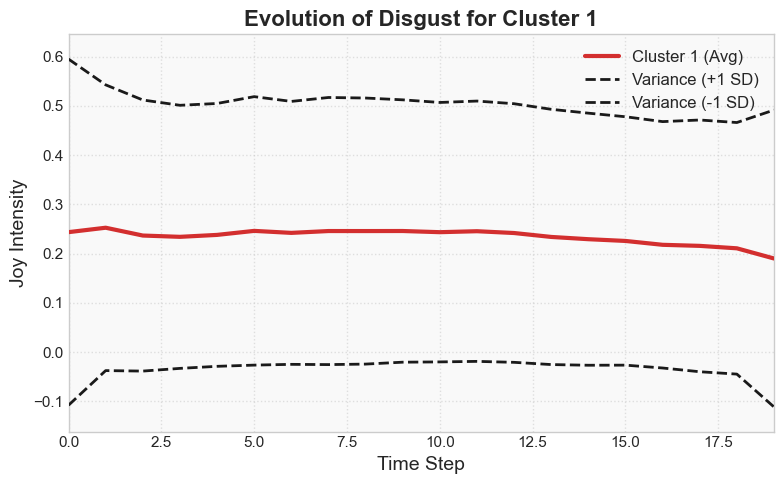

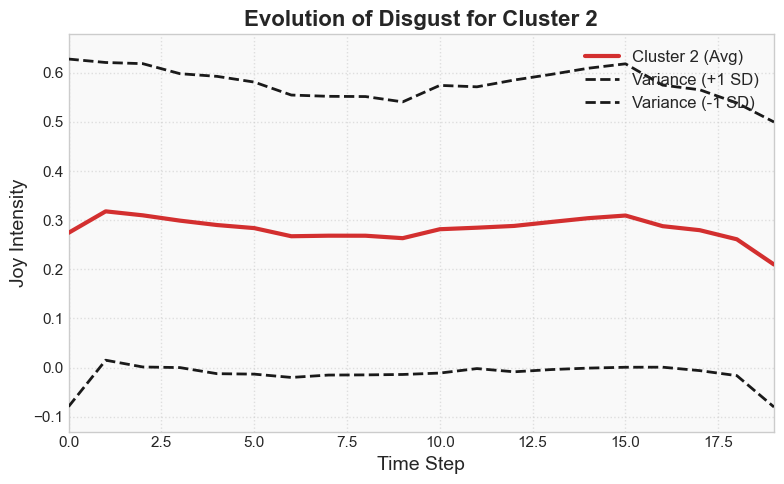

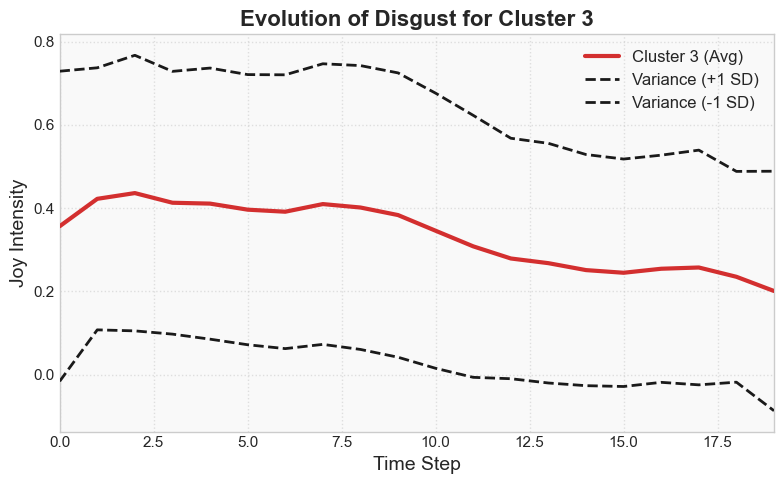

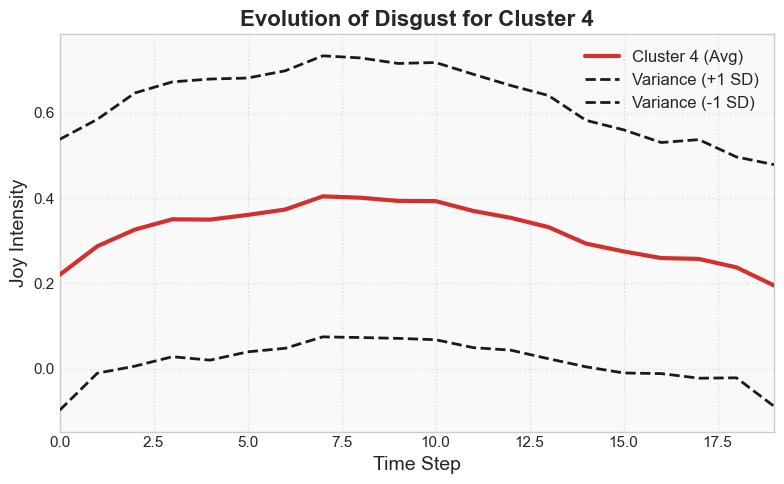

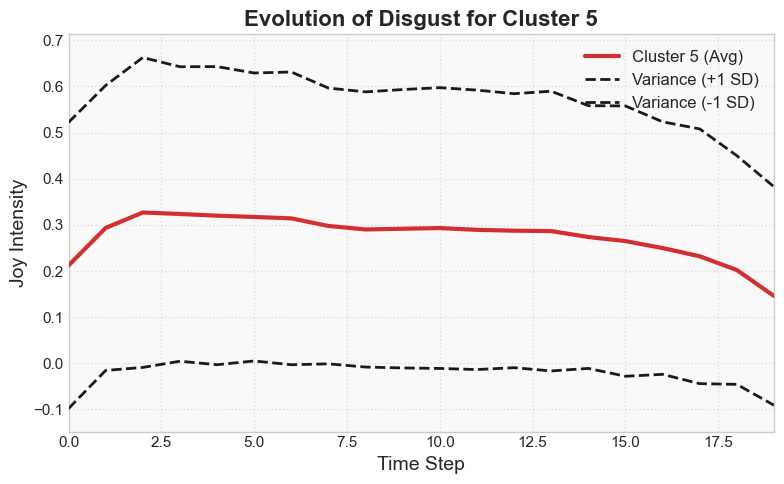

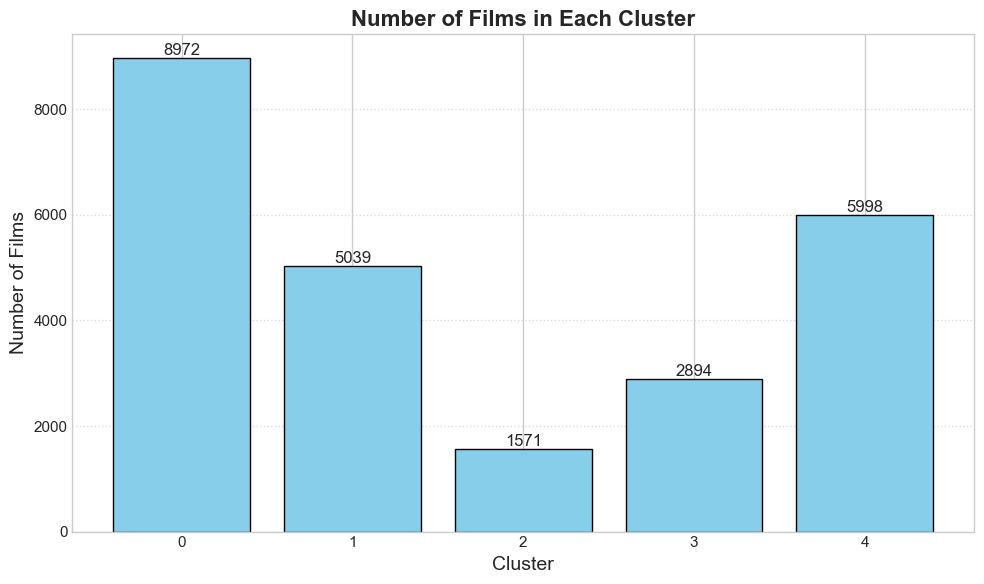

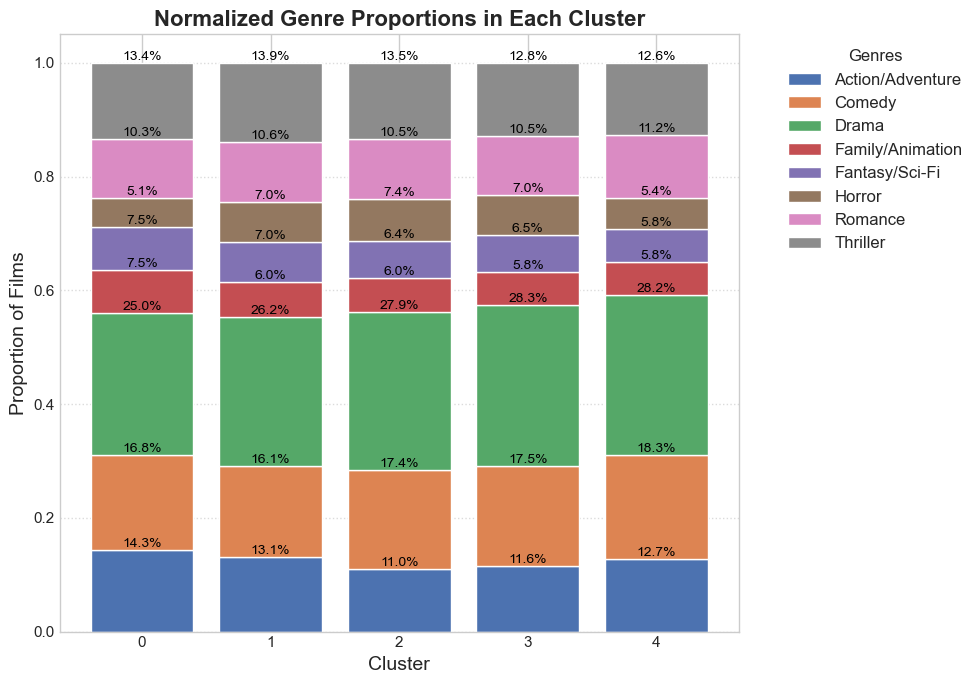

In [72]:
plot_clusters(X_disgust, y_disgust, "Disgust", 5)
plot_clusters_stats(y_disgust_df, df_metadata)

# Fear K-shape

In [75]:
model = KShape(n_clusters=7, verbose=True, random_state=0)
y_fear = model.fit(X_fear).predict(X_fear)
y_fear_df = pd.DataFrame({'Wikipedia_movie_ID': df_genres["Wikipedia_movie_ID"], 'cluster_label': y_fear})

0.105 --> 0.096 --> 0.094 --> 0.093 --> 0.112 --> 


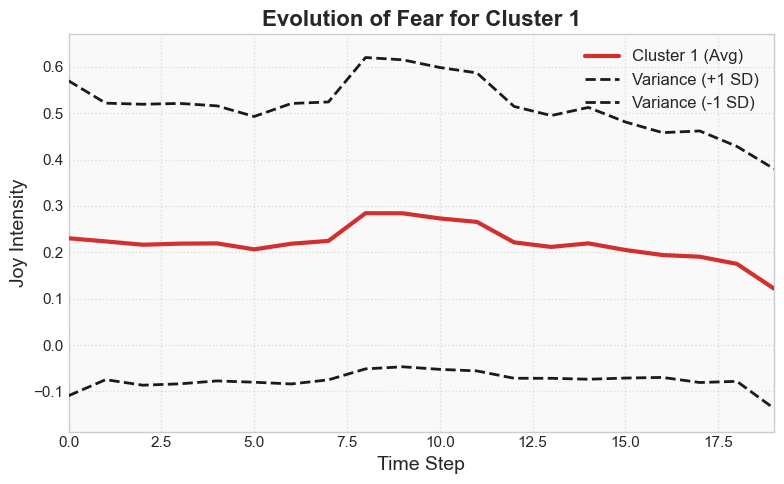

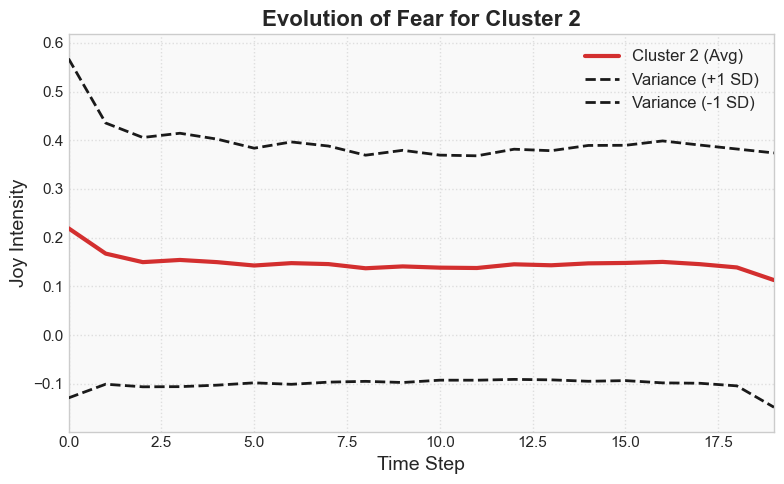

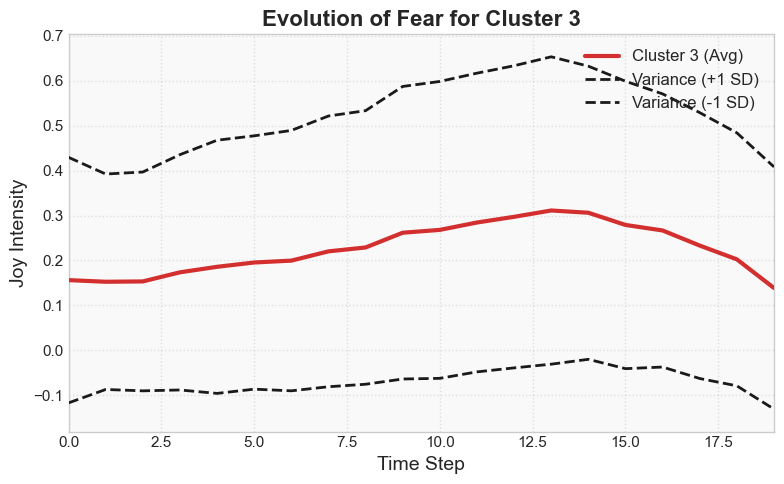

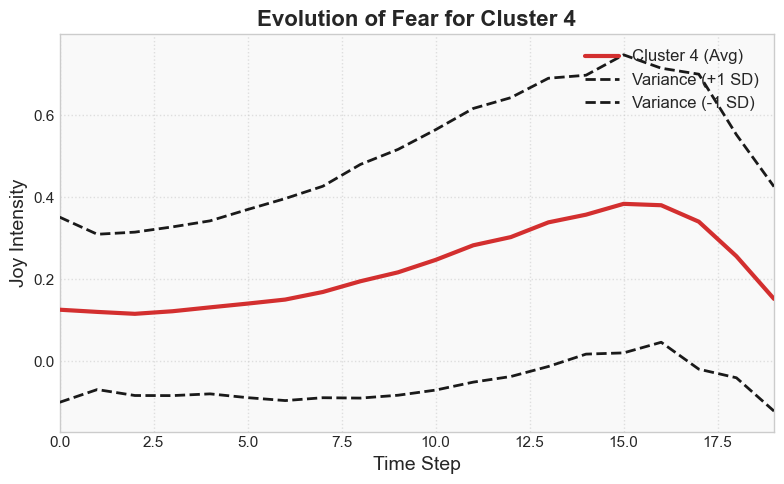

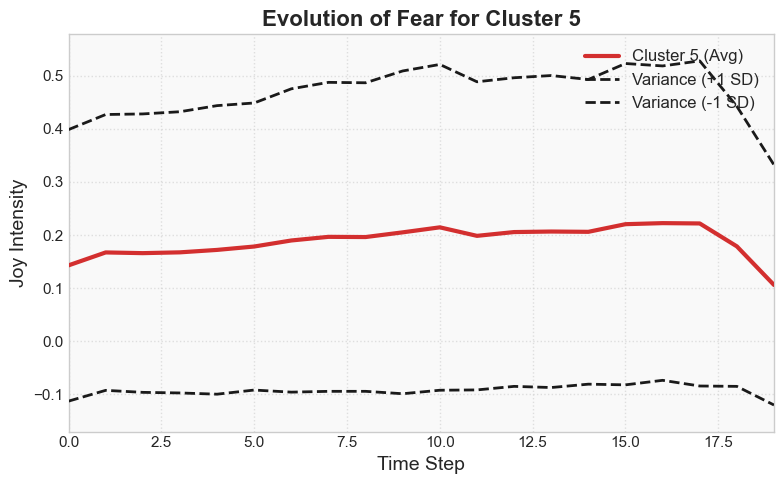

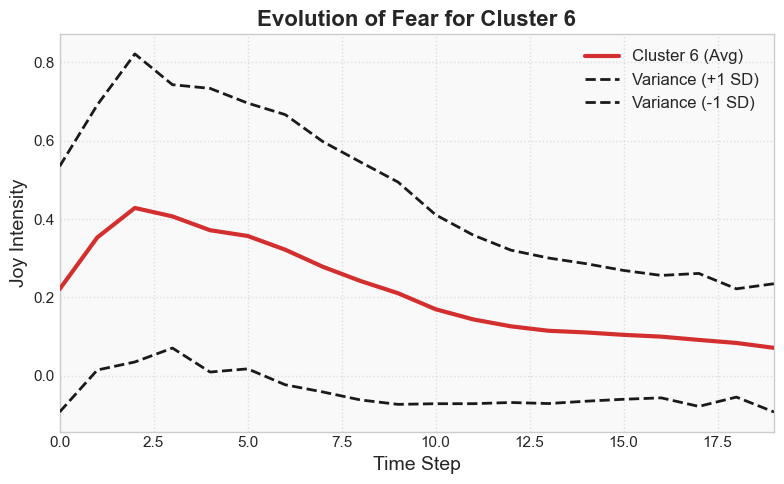

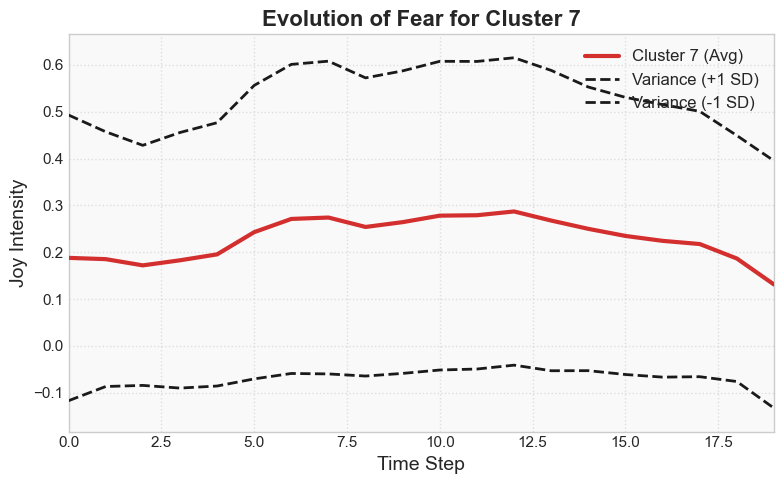

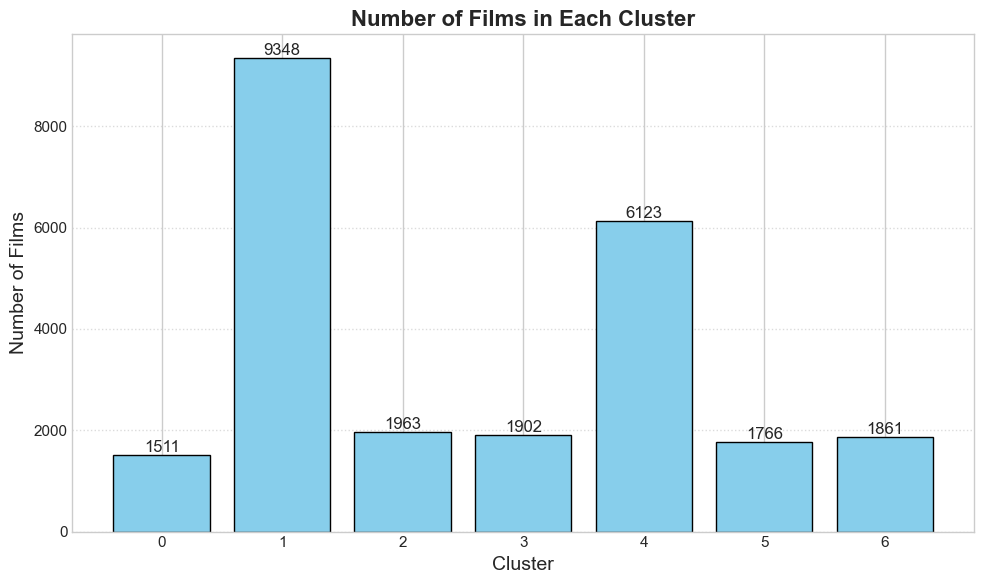

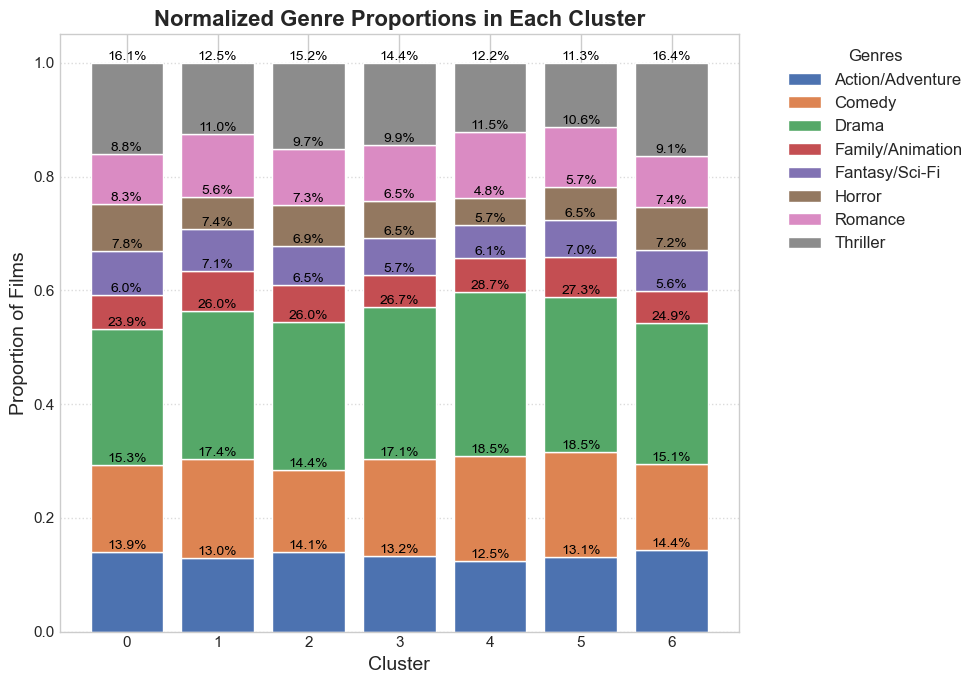

In [76]:
plot_clusters(X_fear, y_fear, "Fear", 7)
plot_clusters_stats(y_fear_df, df_metadata)

### Storing for later use if needed

In [77]:
emotion_columns = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
cluster_results = {
    "anger": y_anger,
    "disgust": y_disgust,
    "fear": y_fear,
    "joy": y_joy,
    "neutral": np.zeros(len(y_joy), dtype=int),
    "sadness": y_sadness,
    "surprise": y_surprise
}
df_cluster_assignments = pd.DataFrame(cluster_results)
df_cluster_assignments.index = df_genres["Wikipedia_movie_ID"]
df_cluster_assignments.head()

,anger,disgust,fear,joy,neutral,sadness,surprise
Wikipedia_movie_ID,,,,,,,
3333,1,0,1,0,0,1,1
3746,4,1,1,0,0,0,1
3837,4,0,1,0,0,0,4
3947,4,2,1,0,0,0,1
4227,3,1,3,0,0,0,1


In [78]:
df_cluster_assignments.to_pickle("../../data/emotions_cluster_assignments.pkl")

# Clustering as a 7D

In [7]:
scaled_emotions = TimeSeriesScalerMinMax().fit_transform(df_emotions.values)

In [ ]:
inertias = []
for k in range(2, 10):  # No tqdm here to avoid nested progress bars
    kshape_model = KShape(n_clusters=k, verbose=False, random_state=0)
    kshape_model.fit(scaled_emotions)
    inertias.append(kshape_model.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), inertias, 'o-', markerfacecolor='red')
plt.title(f"Elbow Method for All Emotions together")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.grid(True, linestyle=":")
plt.show()
